# Использование модели FB Prophet
### Прогнозирование временных рядов с сезонными паттернами и поиск аномалий

In [1]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [2]:
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 14})

In [3]:
# Ссылка на исходные данные
DATA_LINK = r'https://ir.aeroflot.ru/fileadmin/user_upload/files/eng/companys_reporting/Operating_highlights/2021/traffic_figures_03_2021_eng.xls'

# Количество прогнозных периодов для модели
N_PERIODS = 12

### Функции

In [4]:
def load_operational_stats(url: str) -> pd.DataFrame:
    """Function loads data via URL and selects operational parameters.
    :param url: URL to data source in Excel format
    :return: DataFrame with operational data
    """
    data = pd.read_excel(url, header=1)
    # Верхняя часть таблицы - ежемесячный трафик в абсолютном выражении
    data = data.head(39)
    # Убираем пустые строки и столбцы
    data = data.loc[2:, 'Main operating indicators':]
    return data


def select_parameter(df: pd.DataFrame, par: str) -> pd.DataFrame:
    """Function selects a single parameter from operational data
    and returns a cleaned DataFrame with columns=['ds', 'y'].
    :param df: Original DataFrame with multiple parameters
    :param par: Selected parameter
    :return: pd.DataFrame with time steps and selected parameter values
    """
    # Выбираем строку с данными по указанному параметру
    selected_data = df[df['Main operating indicators'] == par].copy()
    # Убираем столбец с ед. изм.
    selected_data.drop('Unnamed: 3', axis='columns', inplace=True)
    # Заменяем перенос строки в названиях столбцов пробелом
    selected_data.columns = selected_data.columns.str.replace('\n', ' ')
    # Преобразуем таблицу в вертикальный формат
    selected_data = pd.melt(selected_data, id_vars=['Main operating indicators'],
                            var_name='ds', value_name='y')
    # Преобразуем периоды в формат datetime с ежемесячной частотой
    selected_data['ds'] = pd.date_range(start='2014-01-01', periods=len(selected_data), freq='M')
    # Убираем лишние столбцы
    selected_data.drop('Main operating indicators', axis='columns', inplace=True)
    return selected_data


def get_forecast(data: pd.DataFrame, n_periods) -> tuple:
    """Function initializes FB Prophet model and trains it,
    produces a monthly forecast for 'n_periods' ahead.
    :param data: DataFrame with time steps and parameter values
    :param n_periods: Number of periods (months) to be forecasted
    :return: Tuple with fitted model and DataFrame with the forecast
    """
    model = Prophet(seasonality_mode='multiplicative', mcmc_samples=300)
    model.fit(data)
    # Временная шкала для прогнозируемого периода
    future = model.make_future_dataframe(periods=n_periods, freq='M')
    forecast = model.predict(future)

    return model, forecast


def calculate_errors(df_retrospect: pd.DataFrame,
                     df_forecast: pd.DataFrame,
                     n_periods: int) -> pd.DataFrame:
    """Function adds predicted values from 'df_forecast' to 'df_retrospect'
    and calculates absolute and relative difference with actual values
    for all past periods.
    :param df_retrospect: DataFrame with retrospective data
    :param df_forecast: DataFrame with predicted parameters returned by FB Prophet model
    :param n_periods: Number of future periods included in 'df_forecast'
    :return: DataFrame with retrospective data
    """
    # Расчетные значения модели без прогнозного периода
    df_retrospect['forecast'] = df_forecast['yhat'].head(len(df_forecast) - n_periods).values
    # Разность прогноза и фактического значения
    df_retrospect['error_abs'] = df_retrospect['forecast'] - df_retrospect['y']
    # Ошибка прогноза в долях от 1
    df_retrospect['error_rel'] = df_retrospect['forecast'] / df_retrospect['y'] - 1
    return df_retrospect


def errors_distribution(df: pd.DataFrame, par: str) -> tuple:
    """Function displays a histogram or absolute or relative errors
    of FB Prophet based on retrospective data.
    :param df: DataFrame with actual data with columns=['ds', 'y']
    :param par: Parameter defining type of errors to be displayed
    (one of 'error_abs' or 'errors_rel')
    :return Tuple of float values containing mean errors and standard deviation for errors
    """
    mean_error = np.round(df[par].mean(), 2)
    std_error = np.round(df[par].std(), 2)
    print(f'Среднее расхождение: {mean_error}\nСтандартное отклонение: {std_error}')

    units = 'тыс. чел.' if par == 'error_abs' else 'в долях от 1'

    df[par].hist(bins=30)
    plt.xlabel(f'Ошибка, {units}')
    plt.ylabel('Частота')
    plt.figtext(0.7, 0.8, f'mean={mean_error}\nstd={std_error}', fontweight="bold")
    plt.title('Расхождение модели с фактическими данными')

    return mean_error, std_error


def plot_anomalies(df: pd.DataFrame, periods: np.array):
    """Function displays actual data with marked anomalous periods.
    :param df: DataFrame with retrospective data and time steps
    :param periods: Array of dates
    """
    max_val = df['y'].max()
    plt.plot(df['ds'], df['y'])
    plt.vlines(periods, ymin=0, ymax=max_val, colors='r', linestyles='dashed')
    plt.ylabel('тыс. человек')
    plt.title('Пассажироперевозки "Аэрофлота"')


def find_anomalous_days(df: pd.DataFrame,
                        par: str,
                        min_threshold: float,
                        max_threshold: float) -> np.array:
    """Function selects anomalous dates based on the threshold of difference
    between values modelled by FB Prophet model and actual values for past periods.
    :param df: DataFrame containing retrospective data, model estimations
    and differences between the modelled values and ground truth
    :param par: Type of difference to be used (one of 'error_abs' or 'error_rel')
    :param min_threshold: Lower boundary for errors (difference between modelled values and ground truth)
    :param max_threshold: Upper boundary for errors
    :return: Array of dates
    """
    df['anomaly'] = False
    # Строки, где расхождение превышает пороговые значения
    df.loc[(df[par] > max_threshold) | (df[par] < min_threshold), 'anomaly'] = True
    anomalous_periods = df[df['anomaly'] == True]['ds'].values

    # График с динамикой показателя и разметкой аномальных дней
    plot_anomalies(df, anomalous_periods)

    return anomalous_periods

### Загрузка исходных данных и визуализация

In [5]:
# Все операционные показатели с января 2014 по март 2021 г.
data = load_operational_stats(DATA_LINK)

# Данные по пассажироперевозкам
pass_data = select_parameter(data, 'Passengers carried')
print(pass_data.head())

          ds       y
0 2014-01-31  2256.3
1 2014-02-28  2157.5
2 2014-03-31  2480.9
3 2014-04-30  2541.8
4 2014-05-31  2858.4


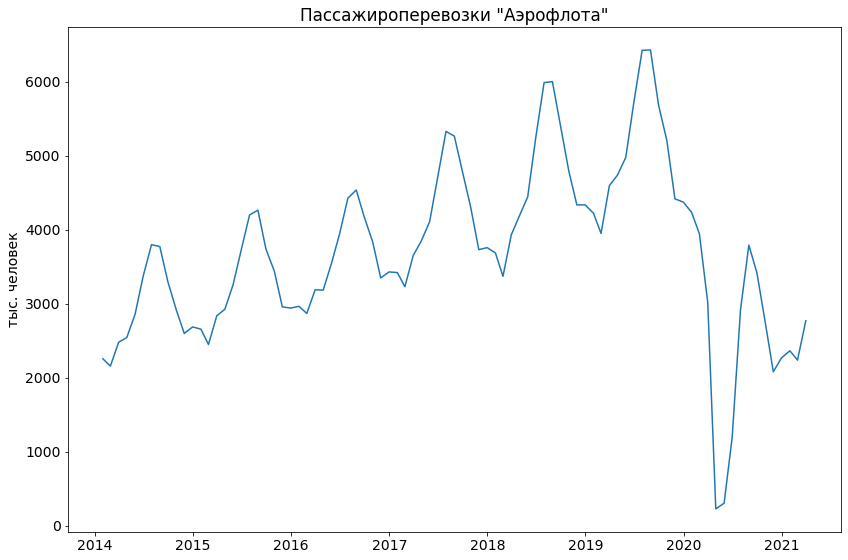

In [6]:
# График с динамикой пассажироперевозок
plt.plot(pass_data['ds'], pass_data['y'])
plt.title('Пассажироперевозки "Аэрофлота"')
plt.ylabel('тыс. человек')
plt.tight_layout()

### Построение модели и прогноз

In [7]:
# Инициализация модели и прогноз
model, forecast = get_forecast(pass_data, N_PERIODS)

# Прогноз и границы доверительного интервала
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(N_PERIODS))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds         yhat   yhat_lower   yhat_upper
87 2021-04-30  2245.527948  1063.571672  3487.399134
88 2021-05-31  2495.968822  1272.060221  3732.949596
89 2021-06-30  2873.600971  1659.879244  4104.268092
90 2021-07-31  3401.620369  2148.928578  4669.179565
91 2021-08-31  3481.340985  2212.361773  4796.304310
92 2021-09-30  2997.362909  1744.139065  4239.922579
93 2021-10-31  2565.952129  1306.536666  3812.094126
94 2021-11-30  2069.795221   840.681832  3335.168734
95 2021-12-31  2103.135533   948.825465  3247.829744
96 2022-01-31  2097.638878   803.134523  3297.641684
97 2022-02-28  1851.847719   640.265766  3046.438541
98 2022-03-31  1955.024378   732.652099  3283.683677


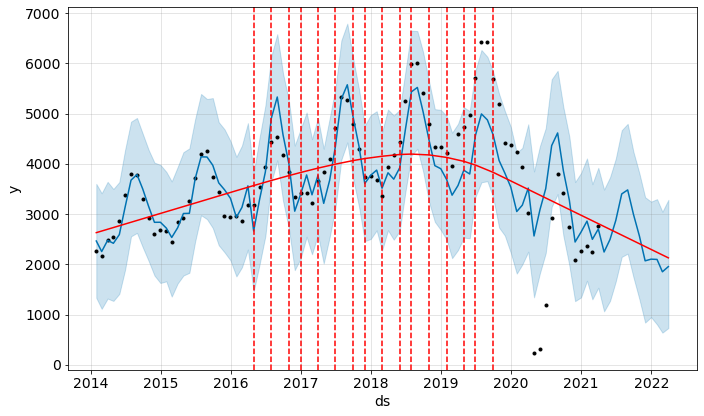

In [8]:
# Визуализация прогноза
fig1 = model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

Как видно по графику, модель идентифицировала точку смены тренда там, где ее на самом деле не было. Уже с 2019 года линия тренда указывает вниз. Фактическое снижение объемов пассажироперевозок началось весной 2020 года, а предшествующий этому год показывал рост операционных показателей.

Синяя линия, показывающая моделируемые значения, в 2019 году проходит значимо ниже фактических данных (показаны черными точками), а в 2020 году - выше. Таким образом, модель постаралась найти оптимальное положение, чтобы максимально приблизиться к данным до и после переломного момента, сохранив при этом характерный сезонный рисунок показателя.

Прогноз на 2021-й - начало 2022 года отрицательный. Модель ожидает дальнейшие снижение показателя. На практике динамика пассажироперевозок в будущем будет определяться внешними факторами, которые невозможно предугадать по предшествующей динамике.

На этом примере наглядно видно, что применение модели FB Prophet имеет объективные ограничения и в ситуациях, когда на динамику показателя оказывают влияние внешние факторы (законодательные ограничения, эпидемиологическая ситуация и др.), интерпретировать прогнозы модели следует с осторожностью.

C:\ProgramData\Anaconda3\envs\Jup_P37\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


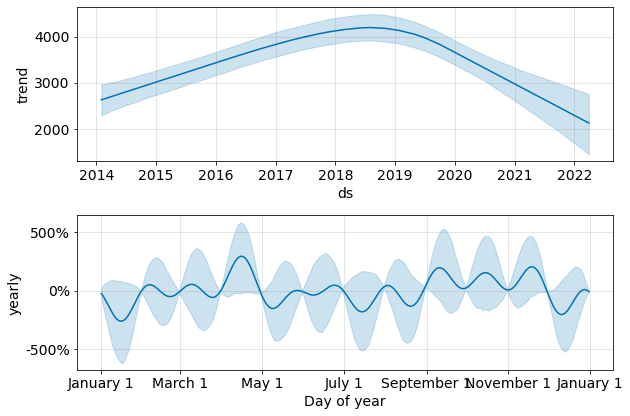

In [9]:
# Разложение временного ряда на компоненты:
fig2 = model.plot_components(forecast)

### Поиск аномалий
Для обнаружения аномалий можно использовать расхождения между фактическими данными и расчетом модели. Периоды наиболее значительных расхождений будут относиться к аномальным.

Для стабильных и волатильных периодов пороговые значения, за пределами которых отклонения будут считаться аномальными, должны различаться. Выбор порогового значения может производиться несколькими способами:
- Аналитический подход: учитывается среднее значение и стандартное отклонение для расхождений модели от фактических данных за весь доступный период наблюдений или за последний, наиболее актуальный период.
- На основе правил, учитывающих особенности конкретного бизнеса. Для авиаперевозчика с учетом суммарной вместимости воздушных судов и действующего расписания вылетов может быть использовано 2 критических значения: минимальный уровень спроса, при котором операционная деятельность все еще остается рентабельной, и максимальный уровень спроса, при котором парк воздушных судов загружен на 100% (постоянное приближение к критическим уровням свидетельствует о необходимости расширить или сократить парк судов и скорректировать расписание вылетов).

#### 1. Поиск аномалий за все время, включая период с марта 2020 г.
В 2020 году падение объема пассажироперевозок было несопоставимо ни с каким другим предшествующим периодом.

In [10]:
# Расчет отклонений модели от фактических данных
pass_data = calculate_errors(pass_data, forecast, n_periods=N_PERIODS)

Среднее расхождение: -34.25
Стандартное отклонение: 709.96


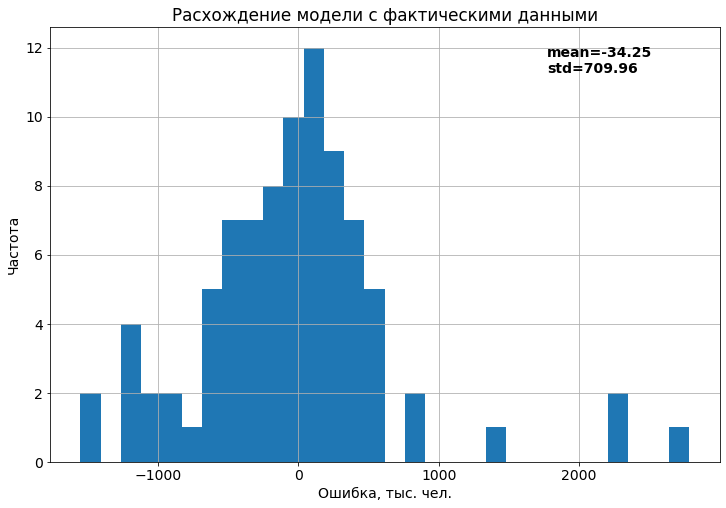

In [11]:
# Расхождения в абсолютном выражении (тыс. чел.)
mean_abs_error, abs_error_std = errors_distribution(pass_data, 'error_abs')

Среднее расхождение: 0.23
Стандартное отклонение: 1.48


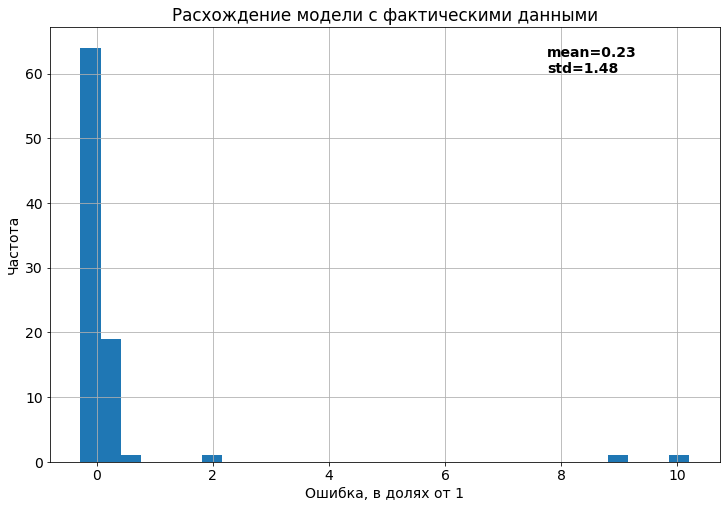

In [12]:
# Расхождения в относительном выражении (в долях от 1)
mean_rel_error, abs_rel_std = errors_distribution(pass_data, 'error_rel')

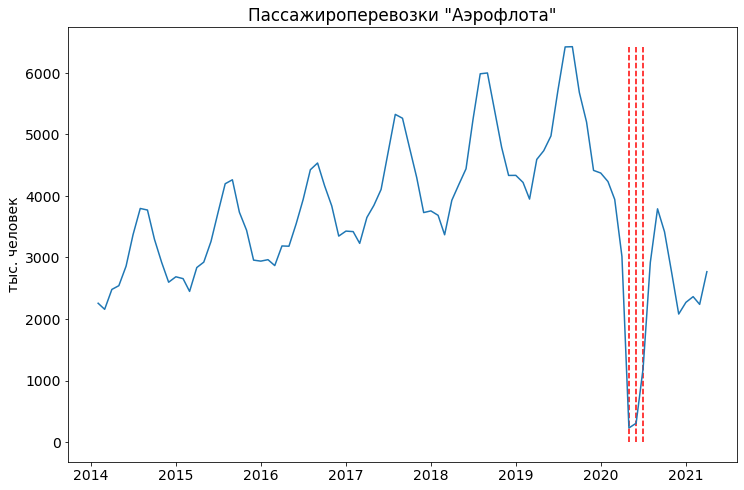

In [13]:
# Аномальные дни за весь период наблюдений
anomalous_days = find_anomalous_days(pass_data, 'error_rel',
                                     min_threshold=mean_rel_error - abs_rel_std,
                                     max_threshold=mean_rel_error + abs_rel_std)

Использование относительного расхождения расчетов модели с фактическими данными о пассажироперевозках в долях от единицы и порогового значения в 1 стандартное отклонение позволяет на долгосрочном периоде найти точки максимальных отклонений: а именно - момент резкого спада пассажироперевозок и следующие за ним несколько месяцев.

Однако дальнейшие периоды уже не интерпретируются моделью как аномальные. По величине отклонений от фактических данных они уступают наиболее кризисному периоду, однако даже визуальный анализ графика показывает, что отнести данные за конец 2020-го - начало 2021 года к нормальным периодам не представляется возможным.

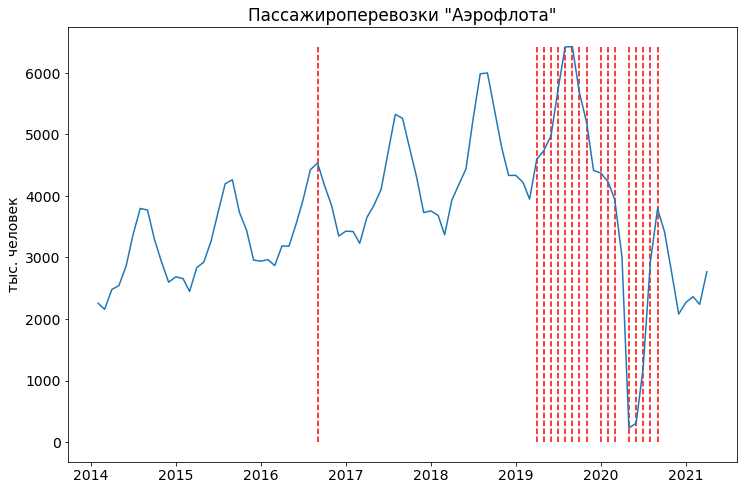

In [14]:
# Аномальные дни за весь период наблюдений
anomalous_days = find_anomalous_days(pass_data, 'error_abs',
                                     min_threshold=mean_abs_error - abs_error_std,
                                     max_threshold=mean_abs_error + abs_error_std)

Если использовать для поиска аномалий абсолютные значения ошибок модели (в тыс. человек), то при пороге в 1 стандартное отклонение в аномальную зону попадает значительная часть 2019 и практически весь 2020 год. Это происходит потому, что, как мы видели выше, модель, подстраиваясь под резкое снижение показателя, нашла среднее положение между фактическими данными до и после переломного момента.

Если обучить модель на данных, не включающих беспрецедентно аномальный 2020 год, то показатели 2019 года не будут интерпретироваться моделью как аномальные.

#### 2. Поиск аномалий за период до 2020 г.

In [15]:
# Берем период до января 2020 г.
pass_data_stable = pass_data[pass_data['ds'] < '2020-02'].copy()

In [16]:
# Повторяем обучение модели, чтобы избежать влияния 2020 г.
# на предшествующие оценки аномальности
model, forecast = get_forecast(pass_data_stable, N_PERIODS)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


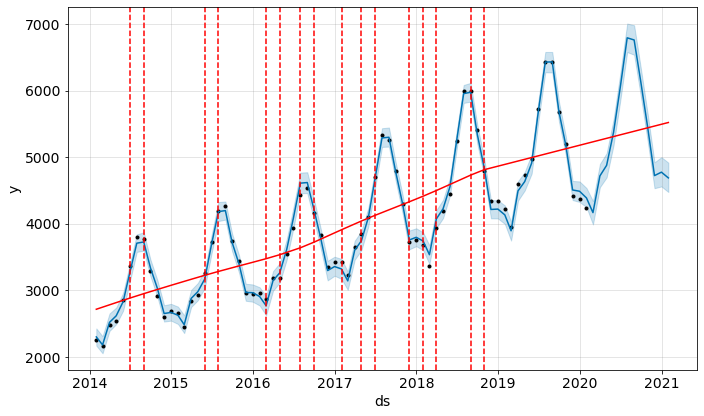

In [17]:
fig1 = model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

Как видно по графику, в относительно стабильный период моделируемые значения проходят значительно ближе к фактическим данным. Но при этом, как мы понимаем, прогноз модели на 2020 год с учетом нашего знания о фактических трендах абсолютно нерелевантен.

In [18]:
# Расчет отклонений модели от фактических данных
pass_data_stable = calculate_errors(pass_data_stable, forecast, n_periods=N_PERIODS)

Среднее расхождение: -0.52
Стандартное отклонение: 73.91


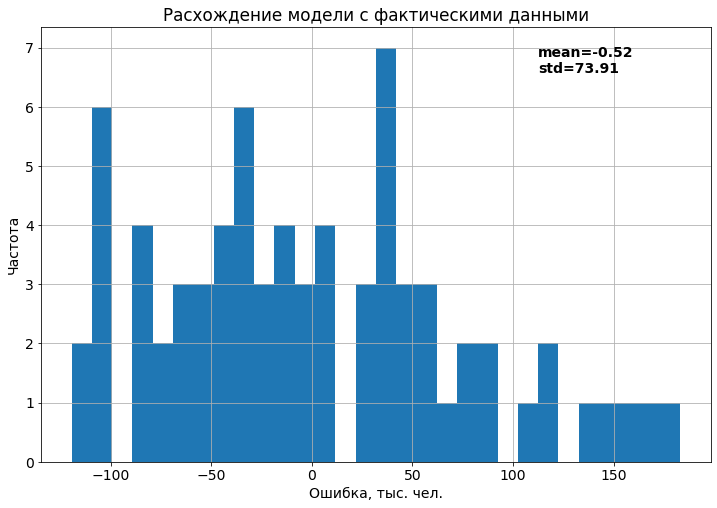

In [19]:
# Расхождения в абсолютном выражении (тыс. чел.)
mean_abs_error, abs_error_std = errors_distribution(pass_data_stable, 'error_abs')

Среднее расхождение: 0.0
Стандартное отклонение: 0.02


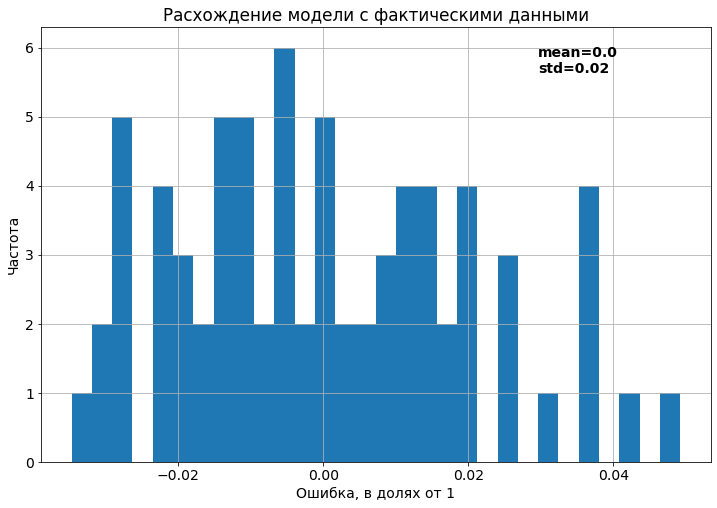

In [20]:
# Расхождения в относительном выражении (в долях от 1)
mean_rel_error, abs_rel_std = errors_distribution(pass_data_stable, 'error_rel')

Отклонения модели от фактических данных как в абсолютном, так и в относительном выражении, довольно незначительны. Поэтому для поиска аномалий в период устойчивого роста пассажироперевозок мы может использовать более высокие пороговые значения. В данном случае используем 1,5 стандартных отклонения от средней ошибки.

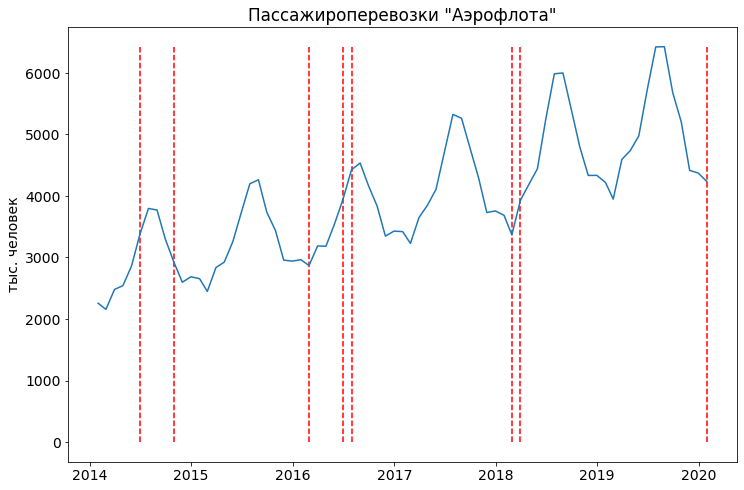

In [21]:
# Аномальные дни за сравнительно стабильный период
anomalous_days = find_anomalous_days(pass_data_stable, 'error_rel',
                                     min_threshold=mean_rel_error - 1.5 * abs_rel_std,
                                     max_threshold=mean_rel_error + 1.5 * abs_rel_std)

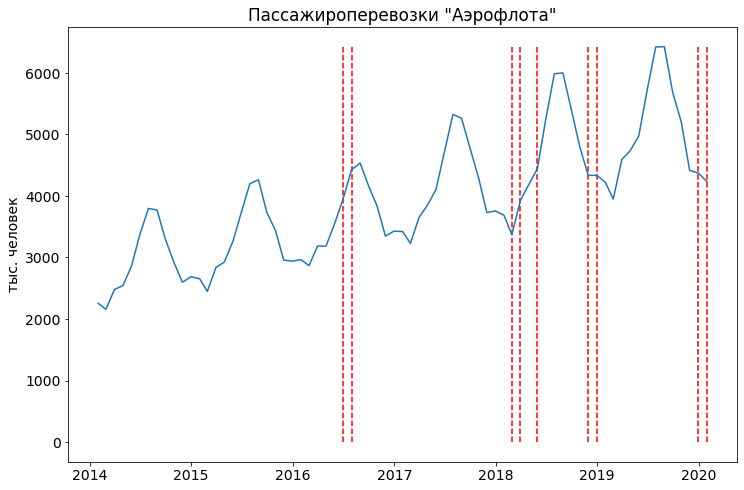

In [22]:
# Аномальные дни за сравнительно стабильный период
anomalous_days = find_anomalous_days(pass_data_stable, 'error_abs',
                                     min_threshold=mean_abs_error - 1.5 * abs_error_std,
                                     max_threshold=mean_abs_error + 1.5 * abs_error_std)

Как видно по графикам, при использовании абсолютных и относительных значений ошибок модели часть найденных аномальных периодов совпадают, а часть - нет. Это связано с тем, что сам объем пассажироперевозок в течение года существенно варьируется. Выбор конкретного способа поиска аномалий должен учитывать особенности авиаперевозчика и критические для него уровни загрузки воздушных судов.

Как один из вариантов можно предложить периодическое обновление прогноза (например, ежемесячное) с учетом последних доступных данных и корректировку расписания вылетов в соответствии с прогнозом. При поступлении фактических данных за следующий период они сравниваются и прогнозом модели. При критических отклонениях от прогноза делается вывод об аномальном поведении показателя. С учетом текущей ситуации и особенностей модели полностью автоматизировать этот процесс не удастся.